In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [2]:

metrics_info = {
    'TTR': False,
    'LD': False,
    'WR': False,
    'MDD': False,
    'SI': False,
    'Cross': False,
    'WSF': False,
    'LIX': False,
    'FRE': True,
    'Fog': False
}


# Welch t-test + Cohen's d + 95% C
def compare_columns(col1, col2):

    # Welch's t-test: Are the means of the two groups statistically different?
    # p_val: If there were actually NO difference between groups, how likely would we observe a difference this large?
    t_stat, p_val = stats.ttest_ind(col1, col2, equal_var=False)

    # Sample sizes
    n1 = len(col1)
    n2 = len(col2)

    # Means
    mean1 = col1.mean()
    mean2 = col2.mean()

    # Variances
    var1 = np.var(col1, ddof=1)
    var2 = np.var(col2, ddof=1)

    # Pooled SD (weighted)
    pooled_sd = np.sqrt(
        ((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)
    )

    # How large the difference is in standardized units
    cohen_d = (mean1 - mean2) / pooled_sd

    # 95% Confidence Interval for mean difference (Welch)
    diff = mean1 - mean2

    se_diff = np.sqrt(var1/n1 + var2/n2)

    # Welch–Satterthwaite df
    df = (var1/n1 + var2/n2)**2 / (
        (var1/n1)**2 / (n1 - 1) +
        (var2/n2)**2 / (n2 - 1)
    )

    t_crit = stats.t.ppf(0.975, df)
    ci_low = diff - t_crit * se_diff
    ci_high = diff + t_crit * se_diff

    return p_val, cohen_d, diff, ci_low, ci_high


# Main comparison function
def compare_holistic_files(df1, df2,nrows = 20):
    df1 = df1.head(nrows)
    df2 = df2.head(nrows)

    results = []

    for metric, higher_better in metrics_info.items():

        col1 = df1[f"{metric}_Holistic"].dropna()
        col2 = df2[f"{metric}_Holistic"].dropna()

        p_val, effect, diff, ci_low, ci_high = compare_columns(col1, col2)

        results.append({
            "Metric": metric,
            "Administrative_mean": col1.mean(),
            "Ausgangstexte_mean": col2.mean(),
            "Mean_difference": diff,
            "CI_lower": ci_low,
            "CI_upper": ci_high,
            "p_value": p_val,
            "Effect_size_d": effect
        })

    results_df = pd.DataFrame(results)

    # Holm correction for multiple test

    results_df["p_adjusted"] = multipletests(
        results_df["p_value"], method="holm"
    )[1]

    # Determine statistically supported "Better"
    def determine_winner(row):
        if row["p_adjusted"] >= 0.05:
            return "No significant difference"

        if metrics_info[row["Metric"]]:  # higher is better
            return "Administrative" if row["Administrative_mean"] > row["Ausgangstexte_mean"] else "Ausgangstexte"
        else:  # lower is better
            return "Administrative" if row["Administrative_mean"] < row["Ausgangstexte_mean"] else "Ausgangstexte"

    results_df["Better"] = results_df.apply(determine_winner, axis=1)

    results_df = results_df.round({
        "Administrative_mean": 3,
        "Ausgangstexte_mean": 3,
        "Mean_difference": 3,
        "CI_lower": 3,
        "CI_upper": 3,
        #"p_value": 4,
        "p_adjusted": 4,
        "Effect_size_d": 3
    })

    return results_df


# Original

In [3]:


# Main comparison function
def compare_Original_files(df1, df2,nrows = 20):
    df1 = df1.head(nrows)
    df2 = df2.head(nrows)

    results = []

    for metric, higher_better in metrics_info.items():

        col1 = df1[f"{metric}_Original"].dropna()
        col2 = df2[f"{metric}_Original"].dropna()

        p_val, effect, diff, ci_low, ci_high = compare_columns(col1, col2)

        results.append({
            "Metric": metric,
            "Administrative_mean": col1.mean(),
            "Ausgangstexte_mean": col2.mean(),
            "Mean_difference": diff,
            "CI_lower": ci_low,
            "CI_upper": ci_high,
            "p_value": p_val,
            "Effect_size_d": effect
        })

    results_df = pd.DataFrame(results)

    # Holm correction for multiple test

    results_df["p_adjusted"] = multipletests(
        results_df["p_value"], method="holm"
    )[1]

    # Determine statistically supported "Better"
    def determine_winner(row):
        if row["p_adjusted"] >= 0.05:
            return "No significant difference"

        if metrics_info[row["Metric"]]:  # higher is better
            return "Administrative" if row["Administrative_mean"] > row["Ausgangstexte_mean"] else "Ausgangstexte"
        else:  # lower is better
            return "Administrative" if row["Administrative_mean"] < row["Ausgangstexte_mean"] else "Ausgangstexte"

    results_df["Better"] = results_df.apply(determine_winner, axis=1)

    results_df = results_df.round({
        "Administrative_mean": 3,
        "Ausgangstexte_mean": 3,
        "Mean_difference": 3,
        "CI_lower": 3,
        "CI_upper": 3,
        #"p_value": 4,
        "p_adjusted": 4,
        "Effect_size_d": 3
    })

    return results_df

df1 = pd.read_csv(
    "https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/qwen3-235b-a22b/Matrix_Scores_qwen3-235b-a22b_Administrative.csv")

df2 = pd.read_csv(
    "https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/qwen3-235b-a22b/Matrix_Scores_qwen3-235b-a22b_Ausgangstexte.csv")


results_df = compare_Original_files(df1, df2)

results_df


,Metric,Administrative_mean,Ausgangstexte_mean,Mean_difference,CI_lower,CI_upper,p_value,Effect_size_d,p_adjusted,Better
0,TTR,0.555,0.468,0.087,0.031,0.144,0.003487,1.000,0.0279,Ausgangstexte
1,LD,0.504,0.539,-0.036,-0.052,-0.020,0.000051,-1.444,0.0005,Administrative
2,WR,0.492,0.484,0.008,-0.010,0.026,0.363621,0.291,1.0000,No significant difference
3,MDD,2.797,2.761,0.035,-0.125,0.196,0.656021,0.143,1.0000,No significant difference
4,SI,0.304,0.345,-0.041,-0.108,0.026,0.217498,-0.398,1.0000,No significant difference
5,Cross,4.550,22.750,-18.200,-28.740,-7.660,0.001756,-1.138,0.0158,Administrative
6,WSF,6.128,6.015,0.113,-0.349,0.575,0.622345,0.157,1.0000,No significant difference
7,LIX,49.579,49.330,0.249,-2.437,2.934,0.852033,0.059,1.0000,No significant difference
8,FRE,40.368,45.197,-4.830,-9.586,-0.074,0.046707,-0.652,0.3269,No significant difference
9,Fog,15.704,14.947,0.757,-0.281,1.796,0.147673,0.468,0.8860,No significant difference


# Qwen

In [ ]:

df1 = pd.read_csv(
    "https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/qwen3-235b-a22b/Matrix_Scores_qwen3-235b-a22b_Administrative.csv")

df2 = pd.read_csv(
    "https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/qwen3-235b-a22b/Matrix_Scores_qwen3-235b-a22b_Ausgangstexte.csv")


results_df = compare_holistic_files(df1, df2)

results_df


,Metric,Administrative_mean,Ausgangstexte_mean,Mean_difference,CI_lower,CI_upper,p_value,Effect_size_d,p_adjusted,Better
0,TTR,0.491,0.305,0.186,0.137,0.235,2.915678e-09,2.433,0.0000,Ausgangstexte
1,LD,0.406,0.476,-0.069,-0.107,-0.032,7.826803e-04,-1.220,0.0063,Administrative
2,WR,0.656,0.616,0.039,-0.029,0.108,2.449871e-01,0.378,0.9209,No significant difference
3,MDD,2.639,2.469,0.170,0.046,0.294,8.361546e-03,0.881,0.0585,No significant difference
4,SI,0.319,0.330,-0.011,-0.051,0.029,5.898874e-01,-0.172,1.0000,No significant difference
5,Cross,5.300,16.600,-11.300,-16.311,-6.289,8.026085e-05,-1.462,0.0007,Administrative
6,WSF,4.196,3.898,0.298,-0.019,0.616,6.441206e-02,0.602,0.3865,No significant difference
7,LIX,39.679,39.330,0.349,-1.643,2.342,7.244637e-01,0.112,1.0000,No significant difference
8,FRE,61.070,63.642,-2.572,-5.690,0.546,1.031769e-01,-0.528,0.5159,No significant difference
9,Fog,10.520,10.072,0.449,-0.296,1.193,2.302215e-01,0.386,0.9209,No significant difference


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_grid_boxplots(df1, df2, nrows=20):

    df1 = df1.head(nrows)
    df2 = df2.head(nrows)

    metrics = list(metrics_info.keys())

    fig, axes = plt.subplots(2, 5, figsize=(18, 8))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):

        col1 = df1[f"{metric}_Holistic"].dropna()
        col2 = df2[f"{metric}_Holistic"].dropna()
        col3 = df1

        ax = axes[i]

        box = ax.boxplot(
            [col1, col2],
            patch_artist=True,
            widths=0.6
        )

        # Administrative → blue
        box["boxes"][0].set_facecolor("lightblue")

        # Ausgangstexte → light orange
        box["boxes"][1].set_facecolor("lightgreen")

        ax.set_title(metric)
        ax.set_xticks([])

    # Adjust layout to create space for legend
    plt.subplots_adjust(bottom=0.15, top=0.90)

    # Create legend handles
    admin_patch = mpatches.Patch(color="lightblue", label="Administrative")
    ausg_patch = mpatches.Patch(color="lightgreen", label="Medical")

    # Place legend centered at bottom
    fig.legend(
        handles=[admin_patch, ausg_patch],
        loc="lower center",
        ncol=2,
        frameon=False
    )


    plt.show()


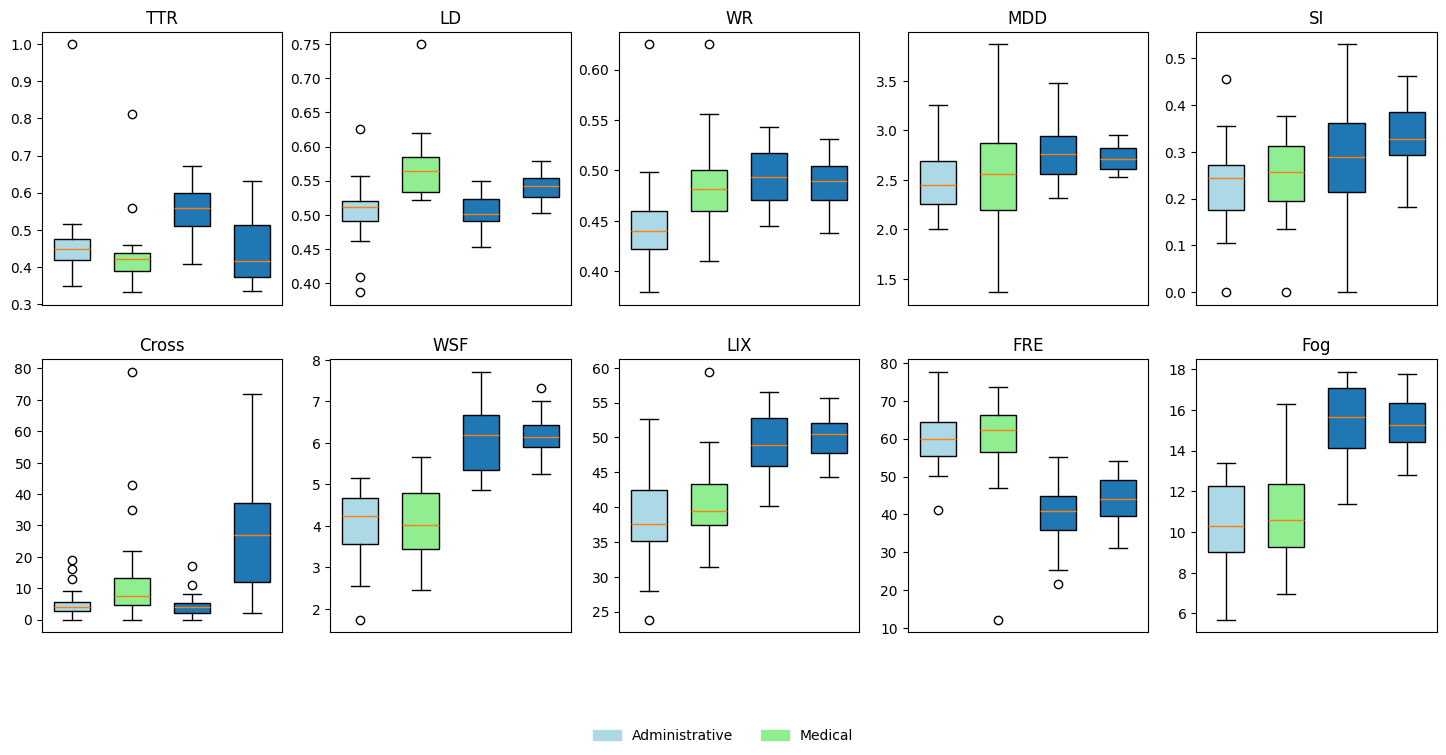

In [ ]:
plot_grid_boxplots(df1, df2, nrows=20)


# Llama

In [ ]:

df1 = pd.read_csv(
    "https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/llama-3.3-70b-instruct/Matrix_Scores_llama-3.3-70b-instruct_Administrative.csv"
)

df2 = pd.read_csv(
    "https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/llama-3.3-70b-instruct/Matrix_Scores_llama-3.3-70b-instruct_Ausgangstexte.csv"
)


results_df = compare_holistic_files(df1, df2)

results_df


,Metric,Administrative_mean,Ausgangstexte_mean,Mean_difference,CI_lower,CI_upper,p_value,Effect_size_d,p_adjusted,Better
0,TTR,0.504,0.512,-0.009,-0.048,0.031,0.663423,-0.139,1.0000,No significant difference
1,LD,0.462,0.501,-0.038,-0.058,-0.018,0.000414,-1.225,0.0041,Administrative
2,WR,0.420,0.432,-0.011,-0.036,0.014,0.359794,-0.293,1.0000,No significant difference
3,MDD,2.255,2.185,0.070,-0.063,0.203,0.296111,0.335,1.0000,No significant difference
4,SI,0.319,0.292,0.028,-0.026,0.081,0.303334,0.330,1.0000,No significant difference
5,Cross,2.550,3.050,-0.500,-2.340,1.340,0.585449,-0.174,1.0000,No significant difference
6,WSF,3.971,4.191,-0.220,-0.729,0.289,0.386586,-0.277,1.0000,No significant difference
7,LIX,36.456,39.280,-2.825,-5.529,-0.120,0.041096,-0.669,0.3699,No significant difference
8,FRE,62.345,60.370,1.975,-3.783,7.733,0.490986,0.220,1.0000,No significant difference
9,Fog,10.641,11.204,-0.563,-1.842,0.715,0.377570,-0.282,1.0000,No significant difference


#GPT 5.1

In [ ]:
df1 = pd.read_csv("https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/GPT_5_1/Matrix_Scores_GPT5_1_Administrative.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/GPT_5_1/Matrix_Scores_GPT5_1_ausgangstexte.csv")

results_df = compare_holistic_files(df1, df2)

results_df


,Metric,Administrative_mean,Ausgangstexte_mean,Mean_difference,CI_lower,CI_upper,p_value,Effect_size_d,p_adjusted,Better
0,TTR,0.466,0.433,0.034,-0.042,0.110,0.374096,0.285,1.0000,No significant difference
1,LD,0.505,0.571,-0.066,-0.098,-0.033,0.000199,-1.302,0.0020,Administrative
2,WR,0.449,0.485,-0.037,-0.068,-0.005,0.024113,-0.743,0.2170,No significant difference
3,MDD,2.526,2.562,-0.036,-0.327,0.255,0.803333,-0.079,1.0000,No significant difference
4,SI,0.231,0.246,-0.015,-0.074,0.043,0.605231,-0.165,1.0000,No significant difference
5,Cross,5.350,14.300,-8.950,-17.942,0.042,0.050991,-0.653,0.4079,No significant difference
6,WSF,4.045,4.119,-0.074,-0.651,0.502,0.795064,-0.083,1.0000,No significant difference
7,LIX,38.399,40.939,-2.541,-6.713,1.632,0.225272,-0.390,1.0000,No significant difference
8,FRE,60.362,59.203,1.159,-5.988,8.306,0.743485,0.104,1.0000,No significant difference
9,Fog,10.280,11.031,-0.751,-2.271,0.769,0.323643,-0.316,1.0000,No significant difference


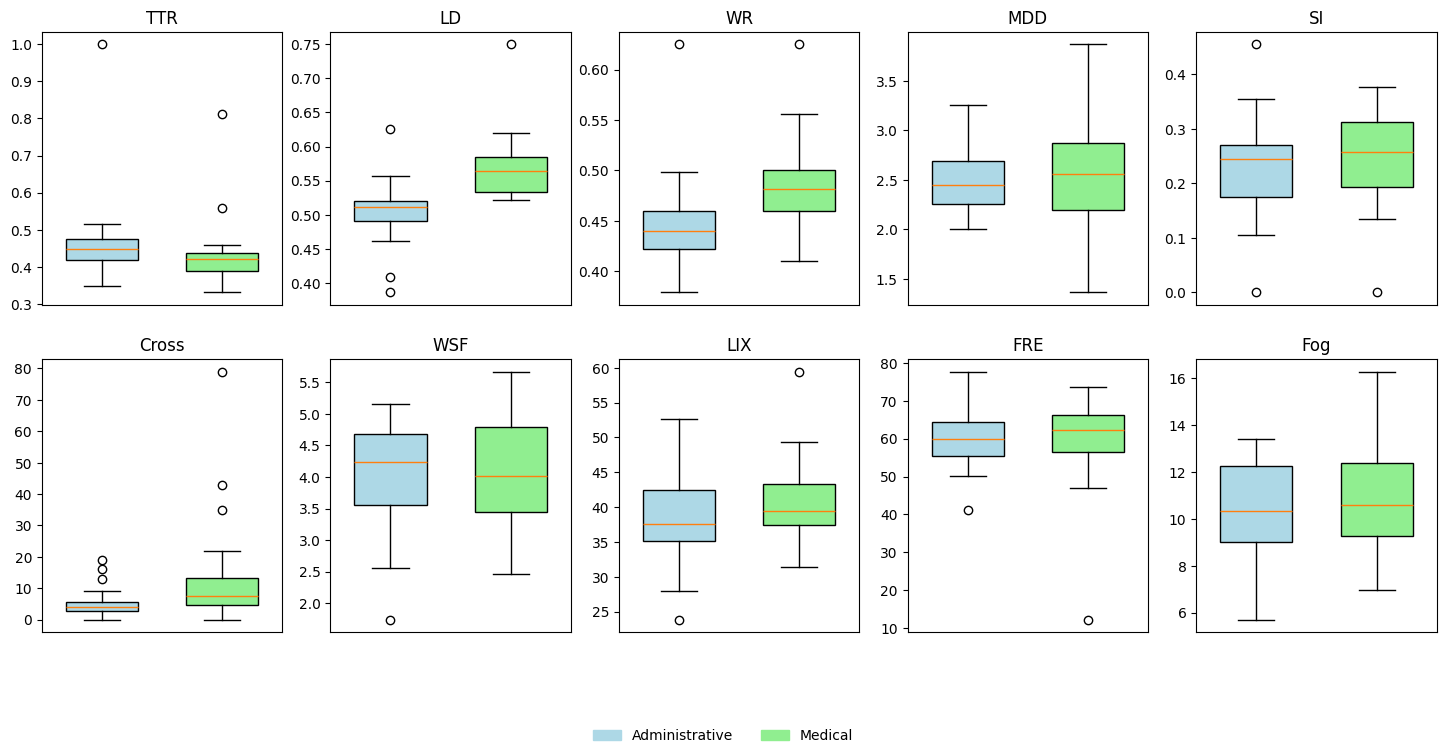

In [ ]:
plot_grid_boxplots(df1, df2, nrows=20)
